In [1]:
%matplotlib inline

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt

from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

# Load images 

In [ ]:
# Function to crop images to same size
def crop_center(img,cropx,cropy):
    y,x = img.shape
    startx = x//2-(cropx//2)
    starty = y//2-(cropy//2)    
    return img[starty:starty+cropy,startx:startx+cropx]

In [36]:
target_names = ["cat", "dog"]
# Target
y = []
# Data
X = None
# Loop through all .jpg files in a directory
for fn in os.listdir("./animals/"):
    if fn.endswith(".jpg"):
        # Get image 
        im = Image.open("./animals/" + fn).convert("L")
        # Crop image
        half_the_width = im.size[0] / 2
        half_the_height = im.size[1] / 2
        im = im.crop(
            (
                half_the_width - 50,
                half_the_height - 75,
                half_the_width + 50,
                half_the_height + 75
            )
        )
        imd = list(im.getdata())
        # Read images into arrays in data
        # Get first
        if X is None:
            X = np.array(imd)
            h, w = np.array(im).shape
        else:
            X = np.vstack((X, imd))
        # Get targets from file name
        fn = fn.partition("-")
        y.append(target_names.index(fn[0]))

### Image Details

In [4]:
X.shape

(8, 15000)

In [5]:
X

array([[191, 188, 186, ..., 172, 167, 154],
       [134, 149, 133, ..., 184, 190, 184],
       [255, 255, 255, ..., 147, 148, 166],
       ...,
       [255, 255, 255, ..., 172, 191, 204],
       [123, 129, 141, ..., 157, 193, 202],
       [242, 242, 242, ..., 192, 187, 185]])

In [6]:
y

[1, 0, 1, 0, 1, 0, 1, 0]

# Split into train and test sets

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0, random_state=42)

In [32]:
X_train.shape

(8, 15000)

# Compute PCA

In [10]:
n_components = 150

pca = PCA(n_components=n_components, svd_solver='randomized', whiten=True).fit(X_train)

In [11]:
eigenanimals = pca.components_.reshape((n_components, h, w))

NameError: name 'h' is not defined

# Train a SCM classification model

# Evaluate the model on the test set 

## Classification report

## Confusion matrix

# Show results

In [43]:
def plot_gallery(images, y, h, w, n_row=2, n_col=4, y_names=None):
    """Function to plot a gallery of portraits"""
    plt.figure(figsize=(1.8 * n_col, 2.4 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((h, w)), cmap=plt.cm.gray)
        if y_names:
            plt.title(y_names[y[i]], size=12)
        else:
            plt.title(y[i], size=12)
        plt.xticks(())
        plt.yticks(())

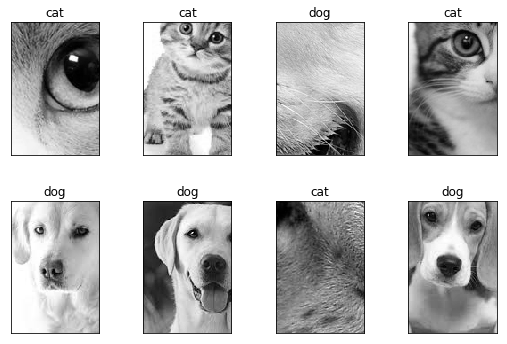

In [46]:
plot_gallery(X_train, y_train, h, w, y_names=target_names)